In [1]:
from BACKGROUND_PYTHON_SCRIPTS.FUNCTIONS.my_functions import *

<div style="background-color: lightblue; padding: 10px 0;">
    <h1 style="text-align: center; font-style: italic; margin: 0;">Data Processor</h1>
</div>

Welcome to the Data Processor! This python script processes all the data of the cross sections you have gathered. The only thing that it needs, is a filled in input file. More information on how to fill in the input file, can be found in the input file itself, in the folder 'INPUT'. 

In order for this notebook to function properly, please make sure the following **required packages** are installed in the currently running Conda Environment.

- Numpy
- Matplotlib
- ipywidgets
- math
- seaborn

Use the following cell if you haven't installed (all) the packages. Uncomment (select and press SHIFT + / ) the applicable lines for you and run (SHIFT + ENTER) the cell.

In [ ]:
# !pip install numpy
# !pip install matplotlib
# !pip install ipywidgets
# !pip install math
# !pip install seaborn

<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Importing Data</h2>
</div>

Before you run this Notebook, make sure that you have inputted the names of the following files for each point in the 'input.xlsx' file:
* Cross profile measurements (.pos file) 
* Waterheight measurments (.pos file) 
* Velocity profile measurements (.csv file) 
* Slope measurements (.pos files)
   
Additionally, the input file asks for the length of the measuring pole and the distance to the bottleneck. 

If you have done all this, load the input file by running the next cell:

In [2]:
input_file = pd.read_excel(f'./input/input.xlsx', sheet_name='Input')

<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Processing Data</h2>
</div>

Now run the following cell. It will generate the following files:
* Hydraulic_parameters.xlsx
  * This file contains a table with the hydraulic parameters (e.g. area, width, hydraulic radius, etc.) from all points that were inputted in the input file
* Pointx_out.csv
  * The script produces a .csv file of the cross section of each point. This is needed for the input of the HEC-RAS model.
* Pointx_out.crossprofile.png
  * The script produces a .png file of the cross section of each point. This is for visualisation purposes. 
* Pointx_velocityprofile.png
  * The script produces a .png file of the velocity profile of each point, of which a velocity profile file is uploaded. 

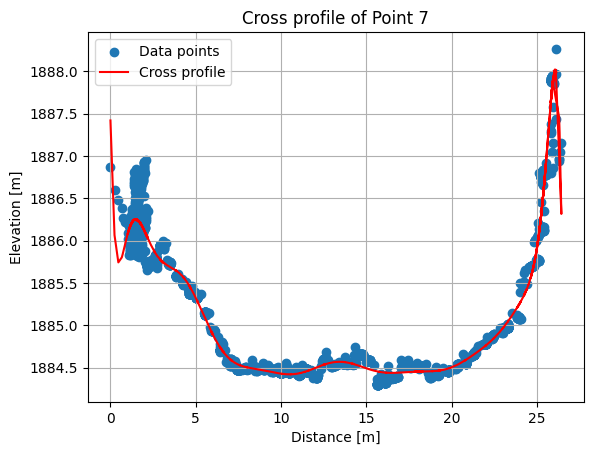

No waterlevel data was found for Point 7


<Figure size 640x480 with 0 Axes>

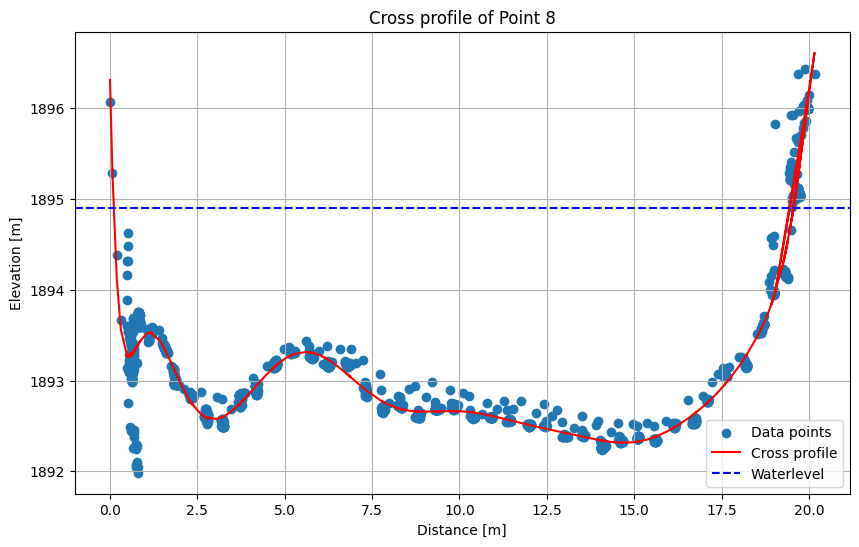

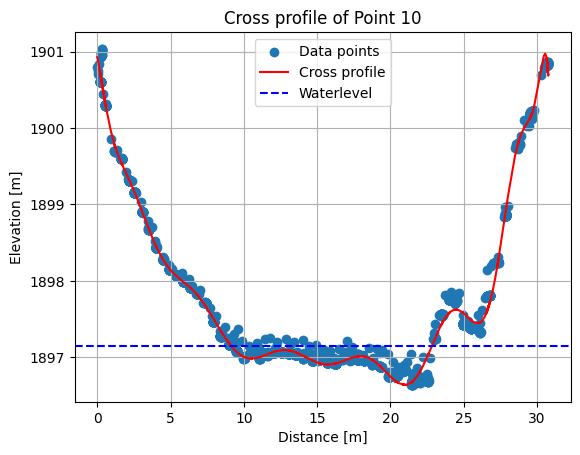

<Figure size 640x480 with 0 Axes>

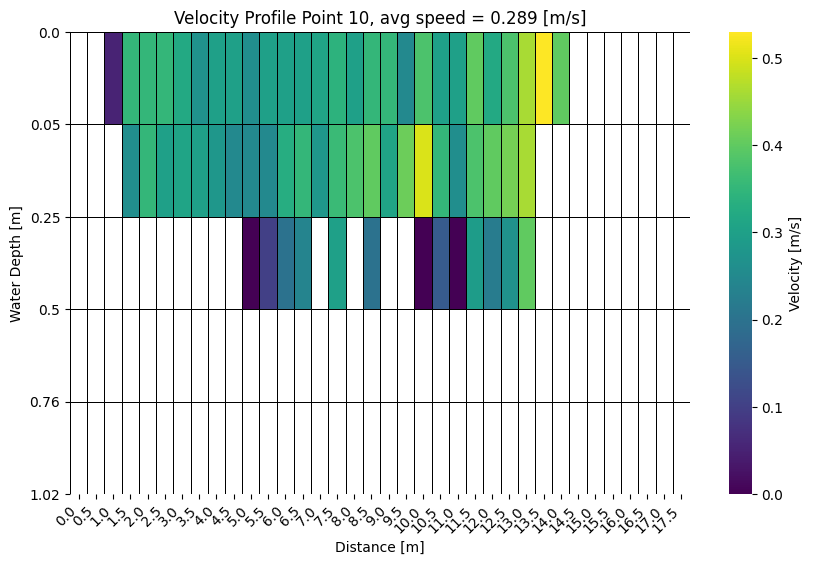

In [8]:
columns = ['pointname', 'distance_to_bottleneck [m]', 'waterlevel [m]', 'mean_depth [m]', 'width [m]', 'area [m2]', 'hydraulic_depth [m]', 'hydraulic_radius [m]', 'avg_flow_velocity [m/s]', 'discharge [m3/s]']
hydraulic_parameters_df = pd.DataFrame(columns=columns)


for i in range(len(input_file)):
    pointname = input_file['pointname'][i]
    cp_filename = input_file['crossprofile_filename'][i]
    w_filename = input_file['waterheight_filename'][i]
    sticklength = input_file['sticklength[m]'][i]
    vp_filename = input_file['velocityprofile_filename'][i]
    dist_bottleneck = input_file['distance_to_bottleneck[m]'][i]

    cp_data = func_read_data(cp_filename, sticklength)
    cp_data['distance(m)'] = func_distance(cp_data['latitude(deg)'], cp_data['longitude(deg)'])
    cp_measurements = cp_data
    
    if pd.notna(w_filename):
        w_data = func_read_data(w_filename, sticklength)
        waterlevel = w_data['height(m)'][-60:-1].mean()
        fitted_values = func_fitline(cp_measurements['distance(m)'], cp_measurements['height(m)'], waterlevel, pointname)
        if waterlevel <= fitted_values.min():
            print('Waterlevel is below the cross section. Please check if there is a mistake in the sticklength or measurements')
        else: 
            hydraulic_parameters = func_hydraulic_parameters(waterlevel, fitted_values, cp_measurements['distance(m)'])

            new_row = {
            'pointname': pointname, 
            'distance_to_bottleneck [m]': dist_bottleneck,
            'waterlevel [m]': waterlevel,
            'mean_depth [m]': hydraulic_parameters[0], 
            'width [m]': hydraulic_parameters[1],
            'area [m2]': hydraulic_parameters[2], 
            'hydraulic_depth [m]': hydraulic_parameters[3], 
            'hydraulic_radius [m]': hydraulic_parameters[4],
            'avg_flow_velocity [m/s]': np.nan,
            'discharge [m3/s]': np.nan
            }

            hydraulic_parameters_df.loc[len(hydraulic_parameters_df)] = new_row
    else:
        fitted_values = func_fitline(cp_measurements['distance(m)'], cp_measurements['height(m)'], 0, pointname)
        new_row = {
        'pointname': pointname, 
        'distance_to_bottleneck [m]': dist_bottleneck,
        'waterlevel [m]': np.nan,
        'mean_depth [m]': np.nan, 
        'width [m]': np.nan,
        'area [m2]': np.nan,
        'hydraulic_depth [m]': np.nan, 
        'hydraulic_radius [m]': np.nan,
        'avg_flow_velocity [m/s]': np.nan,
        'discharge [m3/s]': np.nan
        }
        
        hydraulic_parameters = 0
        hydraulic_parameters_df.loc[len(hydraulic_parameters_df)] = new_row 
        print(f'No waterlevel data was found for {pointname}')
        
    
    export_x = cp_measurements['distance(m)'][0::50]
    export_y = fitted_values[0::50]
    np.append(export_x, cp_measurements['distance(m)'].values[-1])
    np.append(export_y, fitted_values[-1])
    export_data = {"x" : export_x,
               "y" : export_y}
    export_dataframe = pd.DataFrame(export_data)
    export_dataframe.to_csv(f'./output/{pointname}_out.csv', index=False)
    
    if pd.notna(vp_filename):
        avg_flow_velocity = func_velocityprofile(vp_filename, pointname)
        hydraulic_parameters_df.loc[i, 'avg_flow_velocity [m/s]'] = avg_flow_velocity
        if hydraulic_parameters != 0:
            hydraulic_parameters_df.loc[i, 'discharge [m3/s]'] = avg_flow_velocity * hydraulic_parameters[2]
    
slope = func_slope(hydraulic_parameters_df['waterlevel [m]'], 
                   hydraulic_parameters_df['distance_to_bottleneck [m]'])
slopes = slope * np.ones(len(hydraulic_parameters_df))
hydraulic_parameters_df['slope'] = slopes
hydraulic_parameters_df.to_excel('./output/Hydraulic_parameters.xlsx', 
                            sheet_name='Hydraulic Parameters', 
                            index=False)

In [9]:
display(hydraulic_parameters_df)

,pointname,distance_to_bottleneck [m],waterlevel [m],mean_depth [m],width [m],area [m2],hydraulic_depth [m],hydraulic_radius [m],avg_flow_velocity [m/s],discharge [m3/s],slope
0,Point 7,8864,NaN,NaN,NaN,NaN,NaN,NaN,0.457467,NaN,0.000342
1,Point 8,10286,1894.902886,1.988516,19.366604,39.543796,2.041855,1.862592,NaN,NaN,0.000342
2,Point 10,16838,1897.145364,0.203731,13.364638,2.764086,0.206821,0.205235,0.289481,0.800151,0.000342
